In [18]:
from dataclasses import dataclass
import numpy as np
from matplotlib import pyplot as plt

Jos ylimääräisiä tuloutuksia ei ole, yrityksen nettovarallisuus $E$ kasvaa vuodessa oman pääoman tuottoastetta $r$ vastaavalla summalla: jos nettovarallisuus on vuoden alussa $E_0$, se on vuoden lopussa $E_0 (1 + r)$. Oletuksena on, että kaikki tuotot investoidaan kasvuun, jolloin yhteisöveroa ei koidu maksettavaksi.

Jos vuoden päätteeksi yrityksestä maksetaan lisäksi ulos osinko $D$, tuloksesta täytyy sen osalta maksaa yhteisöveroa $t_c$ niin, että nettovarallisuudesta vähenee summa $L$, jolle pätee $D=(1-t_c)L$. Tällöin nettovarallisuus vuoden päätteeksi (ja osingonmaksun jälkeen) on

$$E_1 = E_0 (1 + r) - L = E_0 (1 + r) - \frac{D}{1 + t_c}.$$

Seuraava luokka mallintaa yhden vuoden (tai muun ajanjakson) aikana tapahtuvaa nettovarallisuuden kehitystä.

In [35]:
@dataclass
class Period:
    starting_equity: float      # E_0
    return_on_equity: float     # r
    dividend: float = 0.0       # D
    corporate_tax: float = 0.20 # t_c
    
    def coeff(self, t):
        return np.pow(1 + self.return_on_equity, t)

    def equity(self, t):
        return self.coeff(t) * self.starting_equity

    @property
    def peak_equity(self): #
        return self.equity(1)

    @property
    def final_equity(self): # E_1
        return self.peak_equity - self.dividend / (1 + self.corporate_tax)

    def plottable(self, offset=0, N=16):
        x = np.linspace(0, 1, N)
        y = self.equity(x)
        x = np.append(x, [1])
        y = np.append(y, [self.final_equity])
        return x + offset, y

Esimerkiksi 2 miljoonan arvoinen yritys, jonka oman pääoman tuotto on 15% ja josta nostetaan 100 000 edestä osinkoa, kehittyy tässä mallissa vuoden aikana seuraavasti (osingonmaksu sijoitetaan vuoden loppuun):

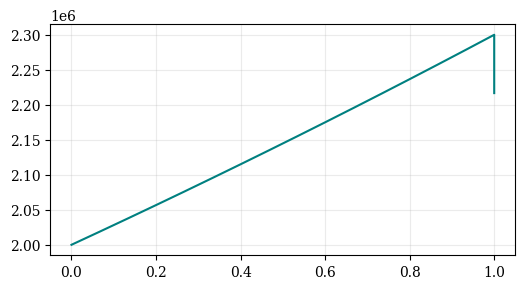

In [45]:
plt.figure(figsize=(6, 3))
period = Period(2_000_000, 0.15, 100_000)
plt.plot(*period.plottable(), color="teal")
plt.show()

In [ ]:
class PeriodChain:
    def __init__(self):
        

In [2]:
class Firm:
    def __init__(self, roe=0.10, ti=0.19, ci=0.40, td=0.34, cd=0.85, tc=0.20):
        self.ti = ti * ci                 # Huojennettu perintövero-%
        self.tc = tc + (1 - tc) * td * cd # Integroitu osinkovero-%
        self.roe = roe                    # Oman pääoman tuotto-%    
        
        self.t = np.array([0])  # Vuotta kulunut sukupolvenvaihdoksesta
        self.a = np.array([10]) # Omaa pääomaa a(t)
        self.fill(20)

    @property
    def A(self): # Omaa pääomaa juuri, kun perintövero on saatu maksettua
        return self.a[10]

    def next(self): # Laske yksi vuosi eteenpäin
        t = self.t[-1] + 1
        a = self.a[-1] * (1 + self.roe)
        if t <= 10:
            p = (self.a[0] * self.ti) / 10 # Perintöveron tasaerä
            a -= p / (1 - self.tc)
        self.t = np.append(self.t, t)
        self.a = np.append(self.a, a)

    def fill(self, N=20): # Laske, kunnes laskettuna on N vuotta
        while len(self.t) < N:
            self.next()

    def inv(self, a): # Millä ajanhetkellä oman pääoman arvo on a?
        return np.interp(a, self.a, self.t)

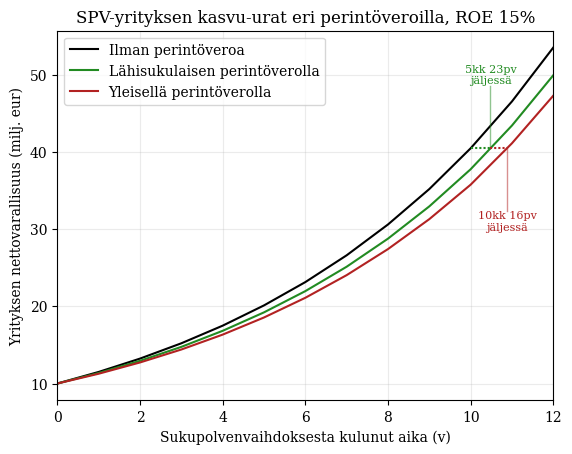

In [3]:
COLORS = ["black", "forestgreen", "firebrick"]
LABELS = ["Ilman perintöveroa", "Lähisukulaisen perintöverolla", "Yleisellä perintöverolla"]
DENSE = (0, (1, 1))

def loss_to_str(years):
    months = int(years * 12)
    days = int(np.round(years * 360 - months * 30))
    return f"{months}kk {days}pv\njäljessä"

def annotate_loss(ax, x0, x, y, i, d):
    s = loss_to_str(x - 10)
    va = "top" if d < 0 else "bottom"
    ax.plot([x0, x], [y, y], color=COLORS[i], linestyle=DENSE)
    ax.plot([x, x], [y, y+d], color=COLORS[i], linewidth=1, alpha=0.5)
    ax.text(x, y + d, s, va=va, ha="center", fontsize=8, color=COLORS[i])

def plot_fixed_roe(ax, roe, N):
    f0 = Firm(roe, 0.00)
    f1 = Firm(roe, 0.19)
    f2 = Firm(roe, 0.33)
    for i, f in enumerate([f0, f1, f2]):
        ax.plot(f.t[:N+1], f.a[:N+1], color=COLORS[i], label=LABELS[i])
    y = f0.A
    x1 = f1.inv(y)
    x2 = f2.inv(y)
    annotate_loss(ax, 10, x1, y, 1, +y/5)
    annotate_loss(ax, x1, x2, y, 2, -y/5)
    ax.set_xlim(0, N)
    ax.set_xlabel("Sukupolvenvaihdoksesta kulunut aika (v)")
    ax.set_ylabel("Yrityksen nettovarallisuus (milj. eur)")
    ax.set_title(f"SPV-yrityksen kasvu-urat eri perintöveroilla, ROE {100*roe:.0f}%")
    ax.legend()

plt.figure()
plot_fixed_roe(plt.gca(), 0.15, 12)
plt.savefig("fig1.png")
plt.show()

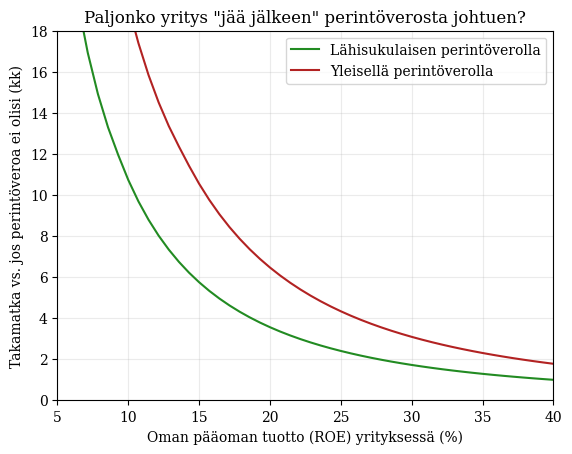

In [4]:
def loss(roe, ti): # Montako vuotta "takamatkaa" perintöverosta aiheutuu?
    f0 = Firm(roe, 0)
    f1 = Firm(roe, ti)
    return f1.inv(f0.A) - 10

def losses(roes): # Takamatka-sarjat eri oman pääoman tuottoprosenteilla
    l1 = np.array([loss(roe, 0.19) for roe in roes])
    l2 = np.array([loss(roe, 0.33) for roe in roes])
    return l1, l2

def plot_per_roe(ax, roes):
    l1, l2 = losses(roes)
    ax.plot(100 * roes, 12 * l1, color=COLORS[1], label=LABELS[1])
    ax.plot(100 * roes, 12 * l2, color=COLORS[2], label=LABELS[2])
    ax.set_xlim(100 * roes[0], 100 * roes[-1])
    ax.set_ylim(0, 18)
    ax.set_xlabel("Oman pääoman tuotto (ROE) yrityksessä (%)")
    ax.set_ylabel("Takamatka vs. jos perintöveroa ei olisi (kk)")
    ax.set_title("Paljonko yritys \"jää jälkeen\" perintöverosta johtuen?")
    ax.legend()

plt.figure()
plot_per_roe(plt.gca(), np.linspace(0.05, 0.40))
plt.savefig("fig2.png")
plt.show()

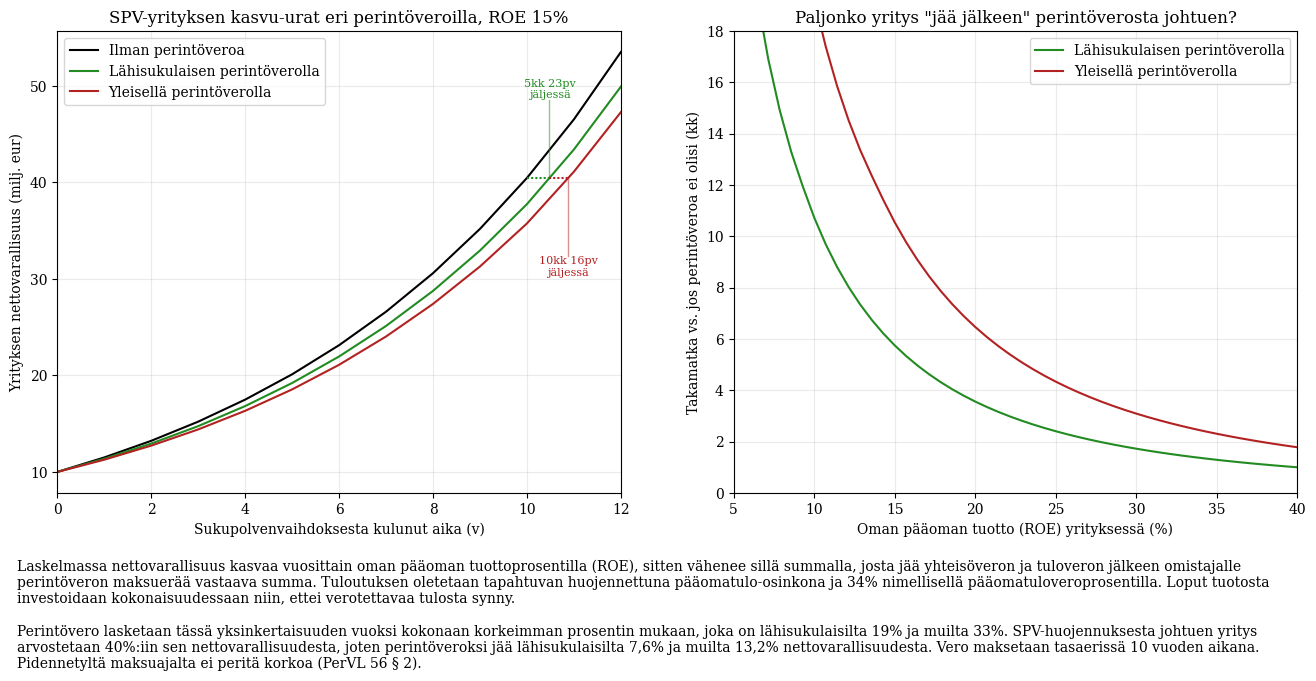

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_fixed_roe(ax[0], 0.15, 12)
plot_per_roe(ax[1], np.linspace(0.05, 0.40))

fig.text(
    0.1,
    0,
    "Laskelmassa nettovarallisuus kasvaa vuosittain oman pääoman tuottoprosentilla (ROE), " +\
    "sitten vähenee sillä summalla, josta jää yhteisöveron ja tuloveron jälkeen omistajalle " +\
    "\nperintöveron maksuerää vastaava summa. Tuloutuksen oletetaan tapahtuvan " +\
    "huojennettuna pääomatulo-osinkona ja 34% nimellisellä pääomatuloveroprosentilla. " +\
    "Loput tuotosta\ninvestoidaan kokonaisuudessaan niin, " +\
    "ettei verotettavaa tulosta synny.\n\n" +\
    "Perintövero lasketaan tässä yksinkertaisuuden vuoksi kokonaan korkeimman prosentin mukaan, " +\
    "joka on lähisukulaisilta 19% ja muilta 33%. SPV-huojennuksesta johtuen yritys\narvostetaan " +\
    "40%:iin sen nettovarallisuudesta, joten perintöveroksi jää lähisukulaisilta 7,6% ja " +\
    "muilta 13,2% nettovarallisuudesta. Vero maksetaan tasaerissä 10 vuoden aikana.\n" +\
    "Pidennetyltä maksuajalta ei peritä korkoa (PerVL 56 § 2).",
    va="top"
)

plt.savefig("fig3.png", bbox_inches="tight")
plt.show()

In [7]:
f = Firm(0.15, 0.19)
f.a

array([ 10.        ,  11.36638537,  12.93772855,  14.74477321,
        16.82287456,  19.21269112,  21.96098016,  25.12151255,
        28.75612481,  32.9359289 ,  37.74270361,  43.40410915,
        49.91472553,  57.40193436,  66.01222451,  75.91405819,
        87.30116691, 100.39634195, 115.45579324, 132.77416223])

In [15]:
p = 10_000 * 0.4 * 0.19
p1 = p / 10
print(f"Perintövero yhteensä: {p} ke")
print(f"Perintövero vuodessa: {p1} ke")

Perintövero yhteensä: 760.0 ke
Perintövero vuodessa: 76.0 ke


In [17]:
11.37 * 1.15 - 0.076

12.999499999999998

In [ ]:
p1 / (

In [ ]:
0.2 + 0.8 * 0.25